### The goal of this XP:
Create a outline image for functional QC in zooniverse platform - Brain Match 
1. Create functionl brain border outline
2. Assemnble left/right funtional brain layout
3. Merge all Layout
3. Visualise in a montage

In [1]:
clear all
% build path
addpath(genpath('../Misc'))
build_path  niak psom zooniverse_qc  

Adding library niak to the search path.

Adding library psom to the search path.

Adding library zooniverse_qc to the search path.



### First create brain outlines

In [2]:
# Set path
path_root = '/home/yassinebha/Drive/QC_zooniverse/';
#path_root = '/media/yassinebha/database29/Drive/QC_zooniverse/';
path_outline = [path_root 'template_layout/brain_outline_bold/'];
path_layout = [path_root 'template_layout/layout/'];

In [3]:
# Reshape 
command_reshape = ['mincresample -clobber ' path_outline 'func_mask_average_stereonl.mnc.gz ' path_outline 'func_mask_average_stereonl_1mm.mnc -like ' path_outline 'mni_icbm152_t1_tal_nlin_asym_09a_mask_dilated5mm.mnc.gz -trilinear'];
system(command_reshape);
[hdr,avg_mask_bold] = niak_read_vol([path_outline 'func_mask_average_stereonl_1mm.mnc']);
[hdr,mask_t1] = niak_read_vol([path_outline 'mni_icbm152_t1_tal_nlin_asym_09a_mask.mnc.gz']);

Transforming slices:.............................................................................................................................................................................................Done


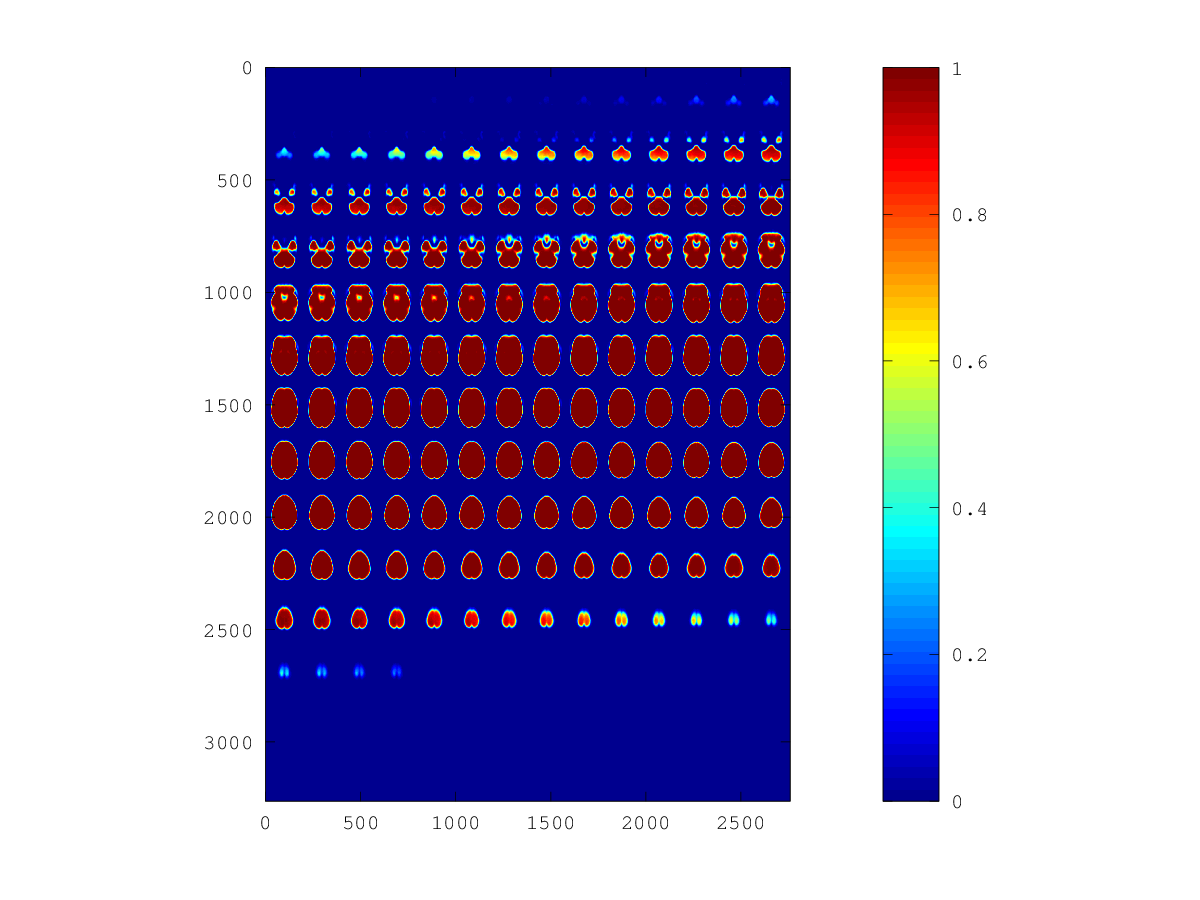

In [4]:
niak_montage(avg_mask_bold)

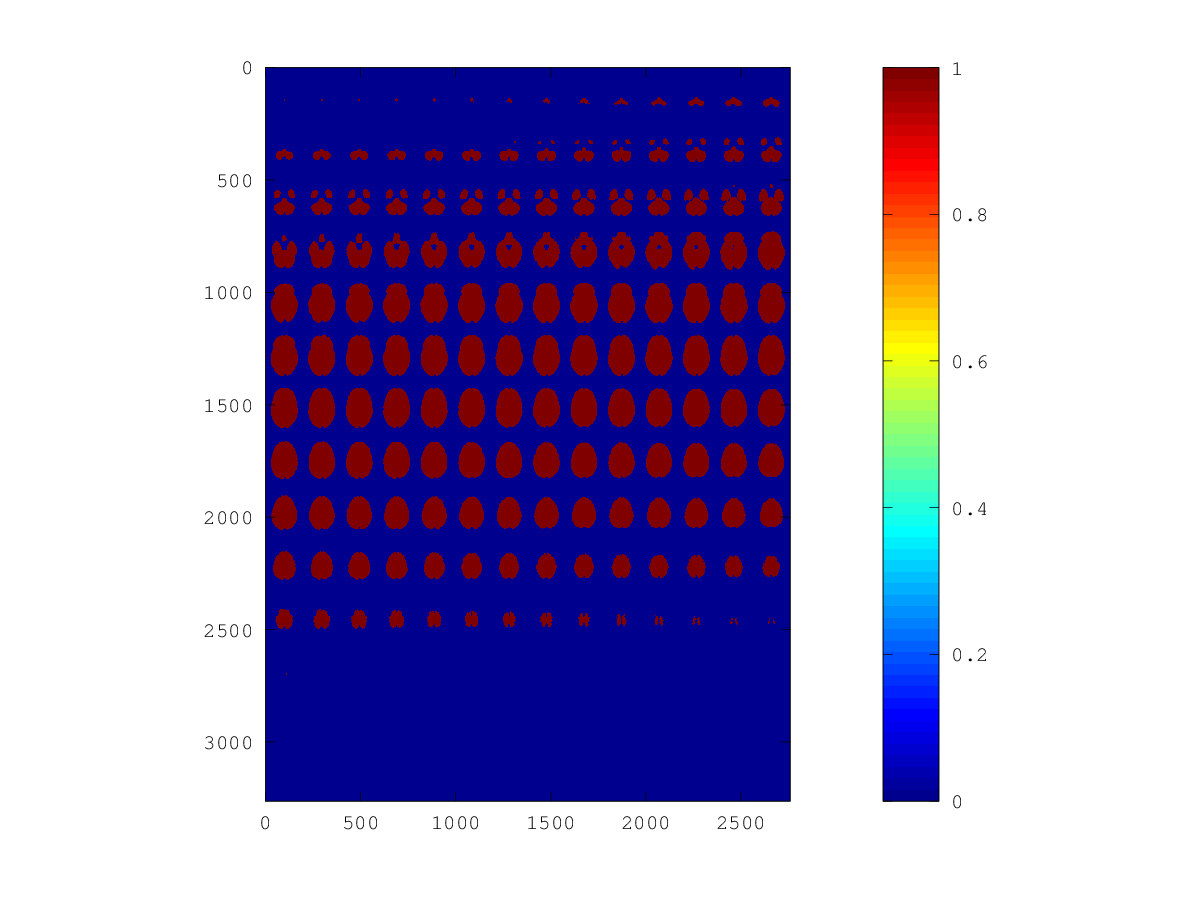

In [5]:
niak_montage(mask_t1)

In [14]:
# Create brain border mask
mask_t1_d = niak_morph(mask_t1,'-successive DDD');
bold_in = avg_mask_bold>0.99;
%bold_out = (avg_mask_bold>0)&~bold_in;
bold_outline = ~bold_in&mask_t1_d;
%mask = bold_out | t1_out;
hdr.file_name = [path_outline 'mask_outline_brain_bold.mnc.gz'];
niak_write_vol(hdr,bold_outline);

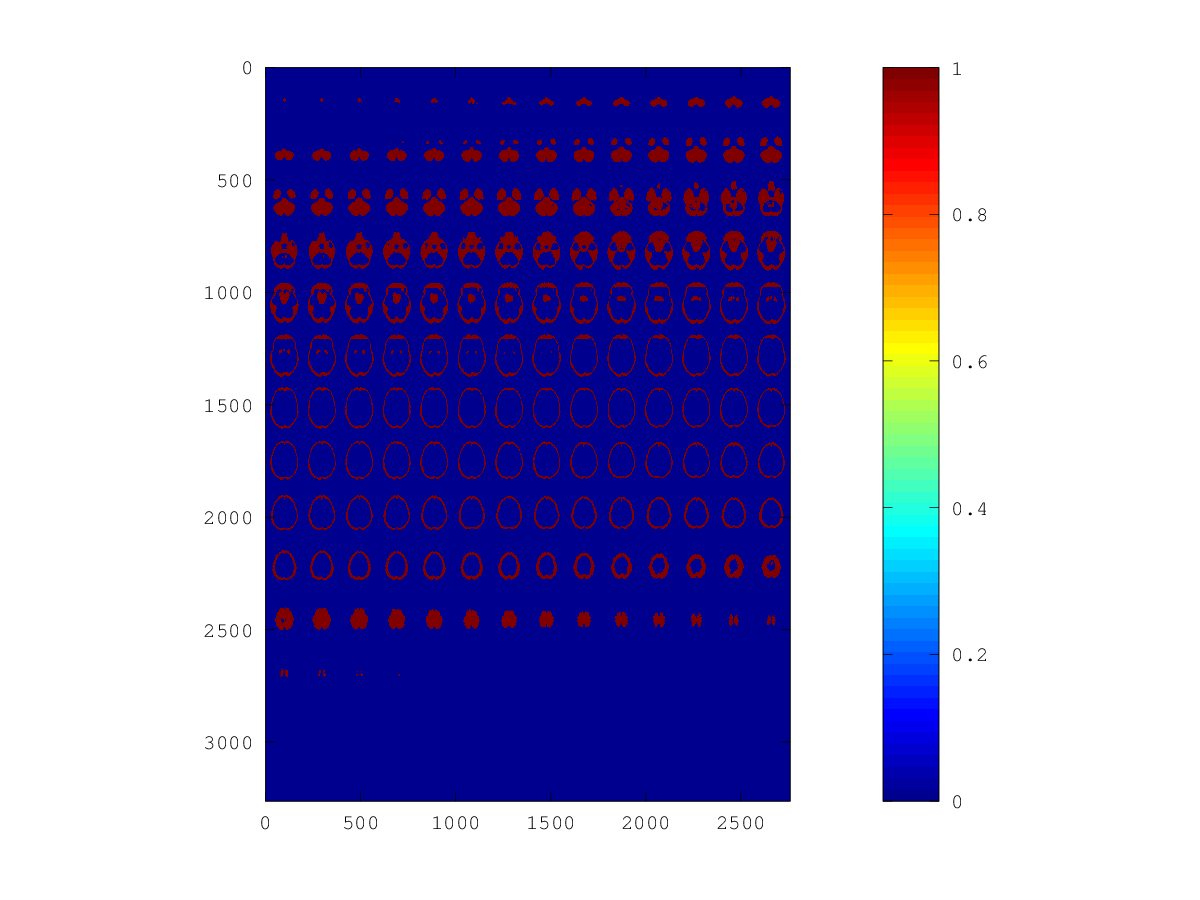

In [7]:
niak_montage(bold_outline)

### Second assemble brain layout

In [8]:
# List layout
list_layout = {(dir([path_layout 'left_*.nii.gz'])).name}

list_layout = 
{
  [1,1] = left_calcarine_sulcus.nii.gz
  [1,2] = left_central_sulcus.nii.gz
  [1,3] = left_cingulate_sulcus.nii.gz
  [1,4] = left_hippocampal_formation.nii.gz
  [1,5] = left_parieto-occipital_fissure.nii.gz
  [1,6] = left_tentorium_cerebelli.nii.gz
  [1,7] = left_ventricul.nii.gz
}


In [9]:
list_exclude = {'left_cingulate_sulcus.nii.gz','left_ventricul.nii.gz'};
list_layout = list_layout(~ismember(list_layout,list_exclude))

list_layout = 
{
  [1,1] = left_calcarine_sulcus.nii.gz
  [1,2] = left_central_sulcus.nii.gz
  [1,3] = left_hippocampal_formation.nii.gz
  [1,4] = left_parieto-occipital_fissure.nii.gz
  [1,5] = left_tentorium_cerebelli.nii.gz
}


In [25]:
# Assemble left right layout volume
[hdr,vol] = niak_read_vol ([path_root 'template_layout/mni_icbm152_gm_tal_nlin_sym_09a.nii.gz']);
vol_final = zeros(size(vol));
for ii=1:length(list_layout)
    fprintf('%s\n',list_layout{ii}(6:end-7))
    [hdr,mask] = niak_read_vol ([path_layout list_layout{ii}]);
    vol_raw = vol;
    vol_raw(mask==0) = 0;
    region = sprintf('%s',list_layout{ii}(6:end-7));
    switch region
        case {'ventricul'}
        vol_t = vol_raw>0.1; 
        case {'calcarine_sulcus'}
        vol_t = vol_raw>0.6;
        case {'tentorium_cerebelli'}
        vol_t = vol_raw>0.5;
        case {'central_sulcus' , 'cingulate_sulcus' , 'hippocampal_formation' , 'parieto-occipital_fissure'}
        vol_t = vol_raw>0.2;
    end   
    hdr.file_name = [path_layout 'mask_layout/mask_' list_layout{ii}] ;
    niak_write_vol (hdr,vol_t);
    hdr.file_name = [path_layout 'mask_layout/mask_right' list_layout{ii}(5:end)];
    vol_transpose = vol_t(end:-1:1,:,:);
    niak_write_vol (hdr,vol_transpose);
    vol_final = vol_final |vol_t | vol_transpose;
end

calcarine_sulcus
central_sulcus
hippocampal_formation
parieto-occipital_fissure
tentorium_cerebelli


In [29]:
hdr.file_name 

ans = /home/yassinebha/Drive/QC_zooniverse/template_layout/layout/mask_layout/mask_all_layout_v2_smoothed.nii.gz


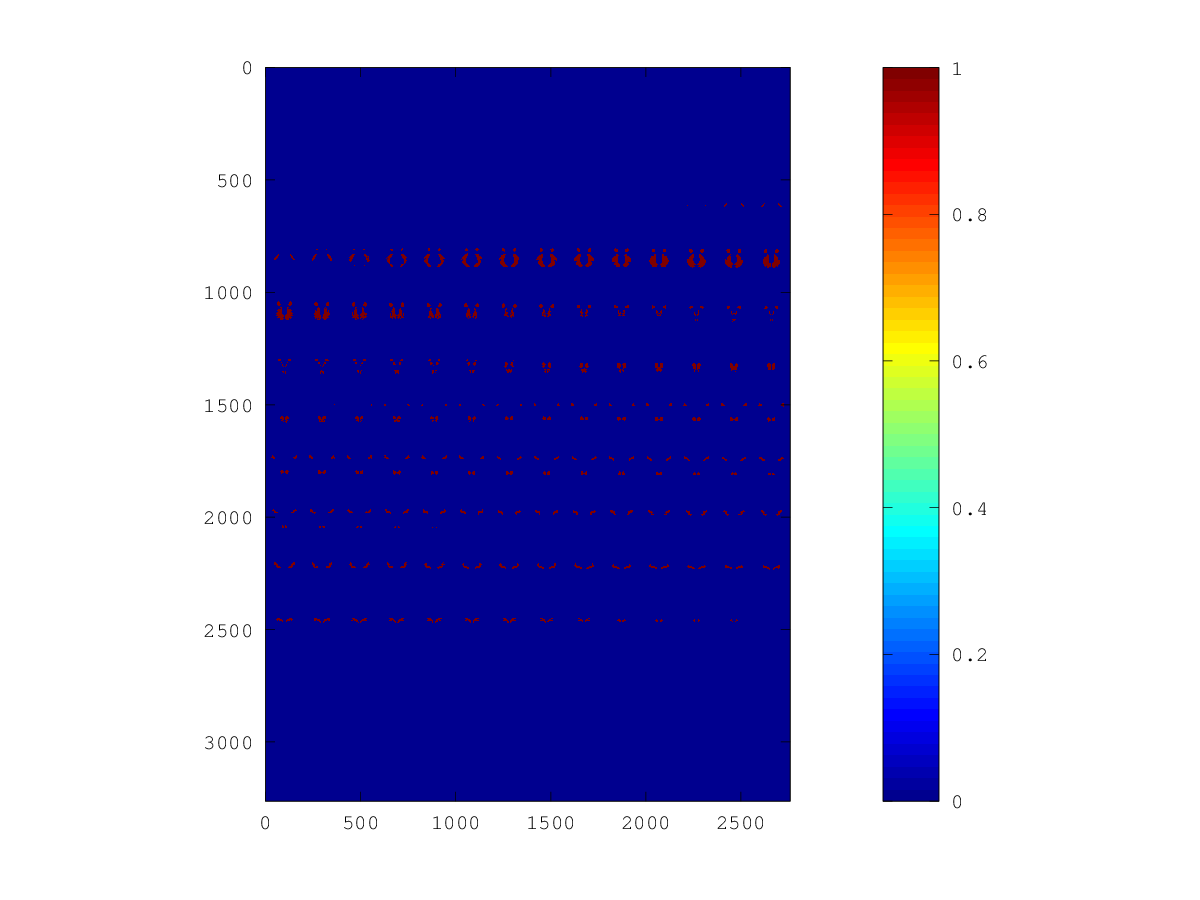

In [26]:
% write layout
hdr.file_name = [path_layout 'layout.nii.gz'];
niak_write_vol (hdr,vol_final);
niak_montage(vol_final)

### Merge all layout

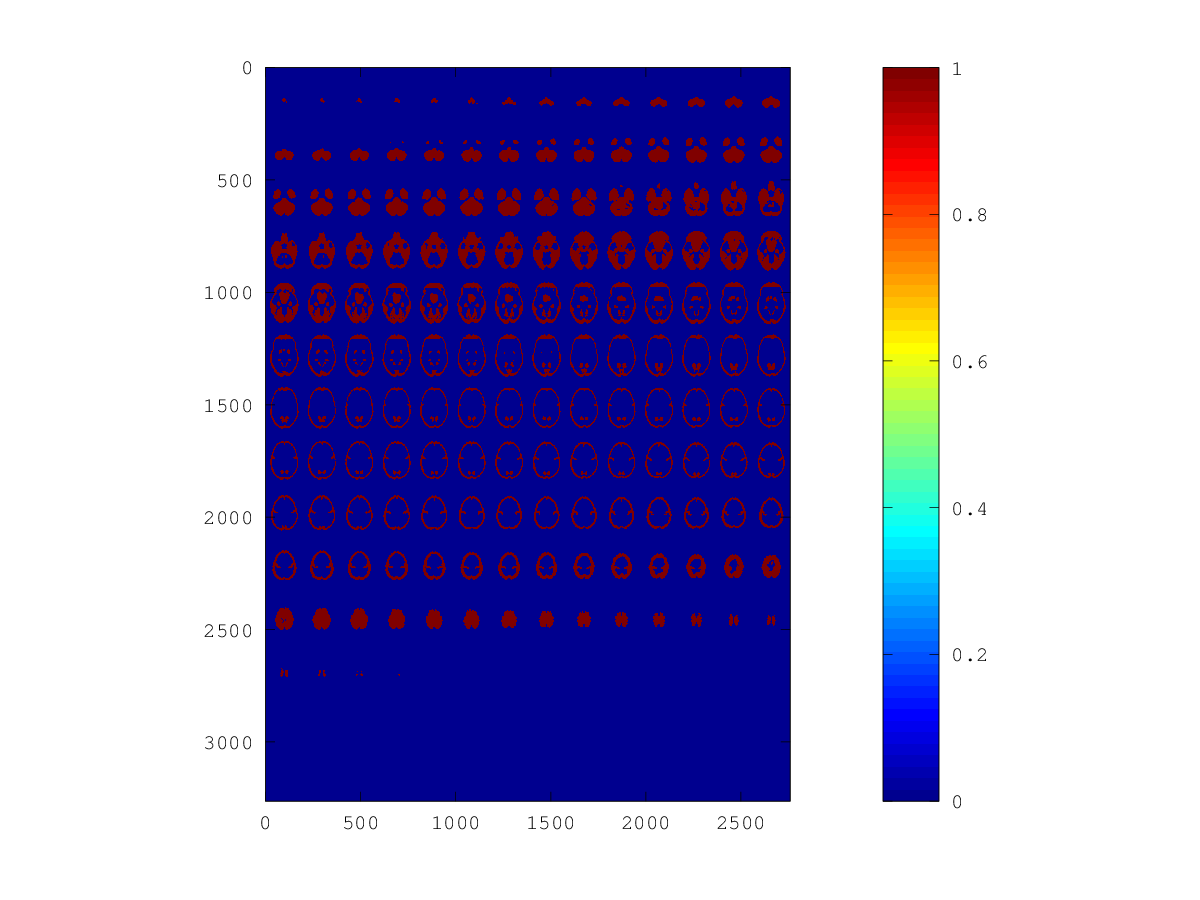

In [27]:
% write final volume layout
vol_final = vol_final | bold_outline;
hdr.file_name = [path_layout 'mask_layout/mask_all_layout_v2.nii.gz'];
niak_write_vol (hdr,vol_final);

% smooth final volume layout
vol_final_s = niak_morph (vol_final,'-successive DDEE');
niak_montage (vol_final_s)
hdr.file_name =  [path_layout 'mask_layout/mask_all_layout_v2_smoothed.nii.gz'];
niak_write_vol (hdr,vol_final_s);

### Create montage of bold layout

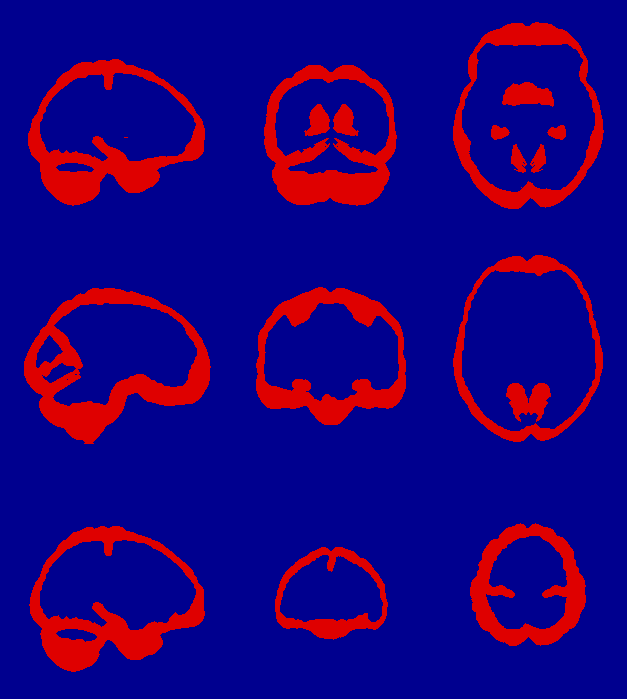

In [28]:
clear jin jout jopt
% Input
niak_gb_vars
jin.source =[path_layout 'mask_layout/mask_all_layout_v2_smoothed.nii.gz'];
jin.target = [ GB_NIAK.path_niak filesep 'template' filesep 'mni-models_icbm152-nl-2009-1.0' filesep ...
'mni_icbm152_t1_tal_nlin_sym_09a.mnc.gz'];

% Output
jout = [path_layout 'mask_layout/mask_all_layout_v2_smoothed.png'];

% Options
jopt.colormap = 'jet';
jopt.colorbar = false;
jopt.flag_decoration = false;
jopt.limits = [0 1.1];
jopt.coord =[-30 , -65 , -6 ; 
             -8 , -25 ,  10 ;  
             30 ,  45 ,  60];
             
% The generation of the montage itself
niak_brick_vol2img(jin,jout,jopt);
imshow(jout)

In [31]:
jin.source

ans = /home/yassinebha/Drive/QC_zooniverse/template_layout/layout/mask_layout/mask_all_layout_v2_smoothed.nii.gz
